---
# **Aprofundando em uma importante métrica de risco: Drawdowns**
---

O Drawdown é um conceito fundamental para investidores, especialmente aqueles que buscam entender a volatilidade de seus investimentos. De forma simplificada, um drawdown representa a maior queda percentual de um investimento em relação ao seu valor máximo anterior.

Entretanto, é comum investidores iniciantes focando apenas no máximo drawdown, ou seja, a maior perda que um investimento já sofreu. No entanto, essa métrica, por si só, pode ser enganosa. Mas quais outras métricas seriam interessantes de se avaliar no drawdown?

* Frequência dos drawdowns: Um investimento com um máximo drawdown baixo, mas com drawdowns frequentes de menor magnitude, pode ser mais arriscoso do que parece.
* Drawdown médio: A média dos drawdowns ao longo de um período pode fornecer uma visão mais realista da volatilidade de um investimento.
* Duração dos drawdowns: O tempo que um investimento leva para se recuperar de um drawdown é crucial. Um drawdown profundo, mas de curta duração, pode ser menos preocupante do que um drawdown menos profundo, mas mais prolongado.
* Duração do período de declínio e recuperação: Além da duração dos drawdowns, é importante conhecer quanto tempo levou até a formação do vale e depois o tempo gasto na recuperação. Além disso, é interessante checar se existe uma razão disproporcional entre tempo de declínio e recuperação.

## 1. Bibliotecas

In [52]:
import numpy as np
import pandas as pd
import datetime

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Análise de drawdown para um ativo

### 2.1. Obter e organizar os dados das cotações

Baixar os dados de fechamento de um ativo pelo yfinance. Para trabalhar com as métricas de duração do drawdown, vamos indicar o índice como frequência diária (incluir os dias sem pregão, já que ali também teríamos um investimento). Depois preenchemos os NaN com "foward fill" (ex., sabado e domingo teriam o preço da cotação de sexta). Nessa função você pode terminar o período de início da análise (padrão máximo período disponível).

In [53]:
def get_stock_prices(ticker, start_date=None):

    data = yf.download(ticker, period='max', auto_adjust=True)[['Close']]
    data = data.asfreq('D')
    data = data.ffill()

    if start_date!=None:
        data = data.loc[start_date:]

    return data

In [54]:
ticker = 'PETR4.SA'
data = get_stock_prices(ticker, start_date='2000-01-01')
data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2000-01-03,1.402440
2000-01-04,1.324858
2000-01-05,1.311490
2000-01-06,1.306954
2000-01-07,1.312922
...,...
2024-07-20,38.689999
2024-07-21,38.689999
2024-07-22,37.919998


### 2.2. Cálculo dos drawdowns e registro das variáveis de interesse

A função "drawdown_records" irá calcular várias métricas de drawdown baseado na evolução do preço ao longo do tempo, linha a linha. Dessa forma, o loop vai preenchendo nossos registros a cada dia avaliado. Dentre as métricas, estão:

* Data do último pico: data da máxima histórica até aquele momento do index;
* Data do vale: data da mínima registrada entre o último pico e a data de recuperação;
* Data de recuperação: data onde o preço igualou ou superou o último pico (fim daquele drawdown)
* Preço do último pico: fechamento da máxima histórica até aquele momento do index;
* Preço do vale: preço da mínima registrada entre o último pico e a data de recuperação;
* Preço de recuperação: preço do dia em que o drawdown foi recuperado;
* Profundidade: percentual entre Preço do vale e Preço do último pico;
* Duração do drawdown: diferença em dias da Data de recuperação e Data do último pico;
* Duração do declínio: diferença em dias da Data do vale e Data do último pico;
* Duração de recuperação: diferença em dias da Data de recuperação e Data do vale;
* Status: recuperado ou ativo (ainda não superou a última máxima histórica)

Para o drawdown ativo, utiliza-se o preço de recuperação como o último preço obtido

In [65]:
def drawdown_records(data):
    # Calcular o drawdown
    data['Peak'] = data['Close'].cummax()
    data['Drawdown'] = data['Close'] / data['Peak'] - 1
    
    drawdowns = []
    drawdown_start = None
    peak_index = None
    
    for i in range(1, len(data)):
        if data['Drawdown'].iloc[i] < 0 and drawdown_start is None:
            drawdown_start = data.index[i]
            peak_index = data['Peak'][:i].idxmax()
        elif data['Drawdown'].iloc[i] == 0 and drawdown_start is not None:
            drawdown_end = data.index[i]
            drawdown_data = data[drawdown_start:drawdown_end]
            valley_index = drawdown_data['Drawdown'].idxmin()
            depth = drawdown_data['Drawdown'].min()*100
            drawdown_duration = (drawdown_end - drawdown_start).days
            decline_duration = (valley_index - drawdown_start).days
            recovery_duration = (drawdown_end - valley_index).days
            drawdowns.append({
                'last_peak_date': peak_index,
                'start_date': drawdown_start,
                'valley_date': valley_index,
                'end_date': drawdown_end,
                'peak_value': data['Peak'][peak_index],
                'valley_value': data['Close'][valley_index],
                'end_value': data['Close'][drawdown_end],
                'depth': depth,
                'drawdown_duration': drawdown_duration,
                'decline_duration': decline_duration,
                'recovery_duration': recovery_duration,
                'status': 'Recovered'
            })
            drawdown_start = None
    
    # Avaliar a situação atual para identificar drawdowns ativos
    if drawdown_start is not None:
        drawdown_end = data.index[-1]
        drawdown_data = data[drawdown_start:drawdown_end]
        valley_index = drawdown_data['Drawdown'].idxmin()
        depth = drawdown_data['Drawdown'].min()*100
        drawdown_duration = (drawdown_end - drawdown_start).days
        decline_duration = (valley_index - drawdown_start).days
        recovery_duration = (drawdown_end - valley_index).days
        status = 'Active'
        drawdowns.append({
            'last_peak_date': peak_index,
            'start_date': drawdown_start,
            'valley_date': valley_index,
            'end_date': drawdown_end,
            'peak_value': data['Peak'][peak_index],
            'valley_value': data['Close'][valley_index],
            'end_value': data['Close'][drawdown_end],
            'depth': depth,
            'drawdown_duration': drawdown_duration,
            'decline_duration': decline_duration,
            'recovery_duration': recovery_duration,
            'status': status
        })
    
    drawdown_df = pd.DataFrame(drawdowns)
    
    return data, drawdown_df

In [66]:
data, drawdown_df = drawdown_records(data)
drawdown_df

,last_peak_date,start_date,valley_date,end_date,peak_value,valley_value,end_value,depth,drawdown_duration,decline_duration,recovery_duration,status
0,2000-01-03,2000-01-04,2000-01-31,2000-03-01,1.402440,1.217676,1.402440,-13.174478,57,27,30,Recovered
1,2000-01-03,2000-03-02,2000-03-02,2000-03-03,1.402440,1.393607,1.441350,-0.629835,1,0,1,Recovered
2,2000-03-09,2000-03-10,2000-04-24,2000-06-21,1.527525,1.193566,1.536835,-21.862778,103,45,58,Recovered
3,2000-06-28,2000-06-29,2000-06-29,2000-07-03,1.638169,1.587442,1.670992,-3.096532,4,0,4,Recovered
4,2000-07-04,2000-07-05,2000-08-09,2000-09-11,1.706799,1.344253,1.718735,-21.241259,68,35,33,Recovered
...,...,...,...,...,...,...,...,...,...,...,...,...
92,2024-02-07,2024-02-08,2024-02-14,2024-02-15,38.232773,37.136524,38.323368,-2.867301,7,6,1,Recovered
93,2024-02-19,2024-02-20,2024-03-11,2024-04-29,38.866962,32.298538,39.256783,-16.899762,69,20,49,Recovered
94,2024-04-29,2024-04-30,2024-04-30,2024-05-02,39.256783,39.135708,39.284725,-0.308417,2,0,2,Recovered
95,2024-05-02,2024-05-03,2024-05-03,2024-05-07,39.284725,38.784981,39.523930,-1.272109,4,0,4,Recovered


### 2.3. Visualização dos drawdowns

Vamos criar dois plots, o primeiro para ver a evolução do preço e marcações dos novos topos, e o segundo para produzir o gráfico underwater

In [67]:
def plot_drawdowns(data):
    plt.figure(figsize=(10, 5))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.plot(data['Peak'], label='Pico')
    plt.fill_between(data.index, data['Close'], data['Peak'], where=data['Close'] < data['Peak'], color='red', alpha=0.3)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(data['Drawdown'], label='Drawdown')
    plt.fill_between(data.index, data['Drawdown'], where=data['Drawdown'] < 0, color='red', alpha=0.3)
    plt.legend()
    plt.show()

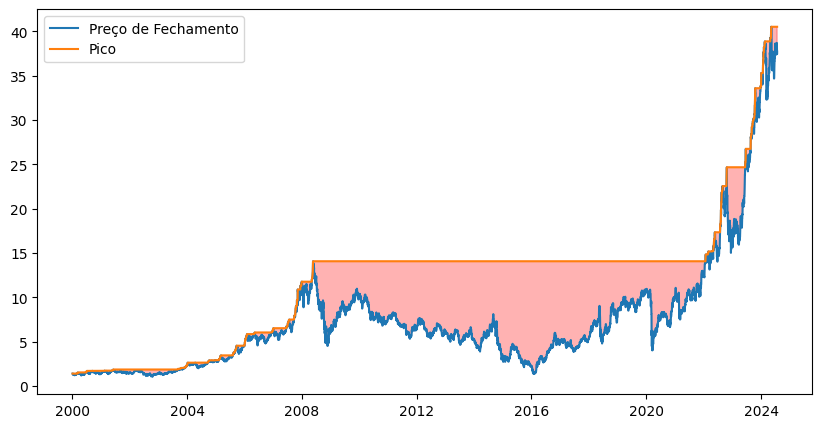

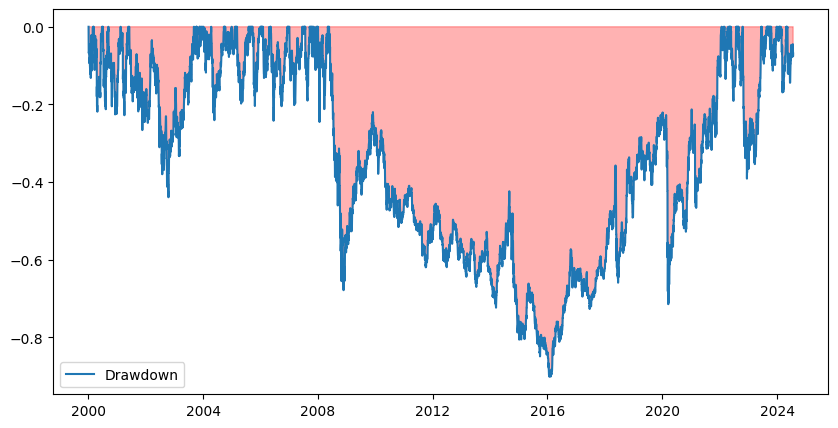

In [68]:
plot_drawdowns(data)

### 2.4. Filtro drawdown mínimo

Vamos voltar ao nosso registro de drawdowns. Observe que existem diversos registros de drawdown, apesar de aguns representarem quedas insignificantes (ex., -0.62%). Isso porque, se um pico foi renovado, basta que no próximo dia o preço caia, já teremos um drawdown registrado. Por isso, é interessante fazer um filtro (mesmo que arbitrário) de quanto será a queda mínima para ser considerado drawdown "verdadeiro".

In [69]:
drawdown_df

,last_peak_date,start_date,valley_date,end_date,peak_value,valley_value,end_value,depth,drawdown_duration,decline_duration,recovery_duration,status
0,2000-01-03,2000-01-04,2000-01-31,2000-03-01,1.402440,1.217676,1.402440,-13.174478,57,27,30,Recovered
1,2000-01-03,2000-03-02,2000-03-02,2000-03-03,1.402440,1.393607,1.441350,-0.629835,1,0,1,Recovered
2,2000-03-09,2000-03-10,2000-04-24,2000-06-21,1.527525,1.193566,1.536835,-21.862778,103,45,58,Recovered
3,2000-06-28,2000-06-29,2000-06-29,2000-07-03,1.638169,1.587442,1.670992,-3.096532,4,0,4,Recovered
4,2000-07-04,2000-07-05,2000-08-09,2000-09-11,1.706799,1.344253,1.718735,-21.241259,68,35,33,Recovered
...,...,...,...,...,...,...,...,...,...,...,...,...
92,2024-02-07,2024-02-08,2024-02-14,2024-02-15,38.232773,37.136524,38.323368,-2.867301,7,6,1,Recovered
93,2024-02-19,2024-02-20,2024-03-11,2024-04-29,38.866962,32.298538,39.256783,-16.899762,69,20,49,Recovered
94,2024-04-29,2024-04-30,2024-04-30,2024-05-02,39.256783,39.135708,39.284725,-0.308417,2,0,2,Recovered
95,2024-05-02,2024-05-03,2024-05-03,2024-05-07,39.284725,38.784981,39.523930,-1.272109,4,0,4,Recovered


Aqui podemos ver que metade dos drawdowns registrados são inferiores a 2.46%

In [70]:
drawdown_df.depth.describe()

count    97.000000
mean     -7.502419
std      12.202024
min     -90.144758
25%      -9.599987
50%      -2.462657
75%      -0.719239
max      -0.021137
Name: depth, dtype: float64

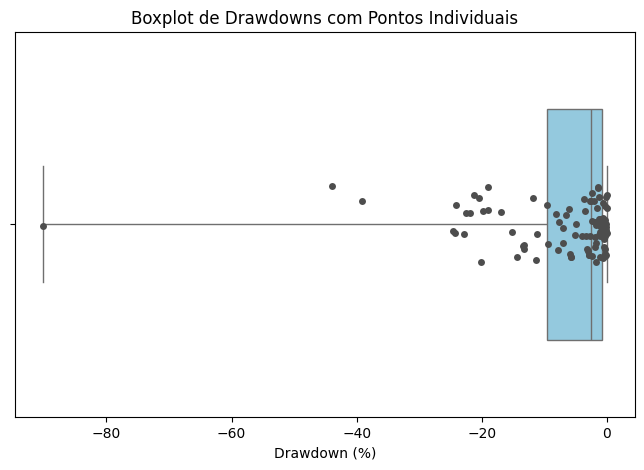

In [71]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='depth', data=drawdown_df, whis=[0, 100], width=0.6, legend=False, color='skyblue')
sns.stripplot(x='depth', data=drawdown_df, size=5, color=".3", linewidth=0)

plt.title('Boxplot de Drawdowns com Pontos Individuais')
plt.xlabel('Drawdown (%)')
plt.show()

### 2.4. Status geral do relatório drawdowns

Para produzirmos nosso relatório com o status geral dos drawdowns, precisamos definir um corte mínimo (cutoff) para excluir da análise drawdowns insignificantes (veja argumentos acima). Vamos definir um corte mínimo de 5%, ou seja, apenas com uma queda de no mínimo 5% do último topo iremos considerar como drawdown. Fique a vontade para definir o nível de corte que mais se adequa às suas análises.

In [72]:
def drawdowns_status(data, drawdown_df, ticker, cutoff=-5):

    drawdown_df = drawdown_df[drawdown_df.depth<=cutoff]
    drawdowns_status = []
    

    drawdowns_status.append({
        'start_date': data.index[0],
        'end_date': data.index[-1],
        'period_covered': (data.index[-1] - data.index[0]).days,
        'n_drawdowns': len(drawdown_df),
        'n_recovered_drawdowns': len(drawdown_df[drawdown_df.status=='Recovered']),
        'n_active_drawdowns': len(drawdown_df[drawdown_df.status=='Active']),

        'active_drawdown_%': ((drawdown_df.end_value.iloc[-1]/drawdown_df.peak_value.iloc[-1] -1) *100).round(3),
        'active_max_drawdown_%': ((drawdown_df.valley_value.iloc[-1]/drawdown_df.peak_value.iloc[-1] -1) *100).round(3),
        'active_drawdown_duration_days': (drawdown_df.end_date.iloc[-1] - drawdown_df.last_peak_date.iloc[-1]).days,
        'active_decline_duration_days': (drawdown_df.valley_date.iloc[-1] - drawdown_df.last_peak_date.iloc[-1]).days,
        'active_recovery_duration_days': (drawdown_df.end_date.iloc[-1] - drawdown_df.valley_date.iloc[-1]).days,

        'max_drawdown_%': drawdown_df.depth.min().round(3),
        'min_drawdown_%': drawdown_df.depth.max().round(3),
        'avg_drawdown_%': drawdown_df.depth.mean().round(3),

        'max_drawdown_duration_days': drawdown_df.drawdown_duration.max().round(3),
        'avg_drawdown_duration_days': drawdown_df.drawdown_duration.mean().round(3),

        'max_decline_duration_days': drawdown_df.decline_duration.max().round(3),
        'avg_decline_duration_days': drawdown_df.decline_duration.mean().round(3),

        'max_recovery_duration_days': drawdown_df.recovery_duration.max().round(3),
        'avg_recovery_duration_days': drawdown_df.recovery_duration.mean().round(3),
        'avg_decline_recovery_duration_ratio': (drawdown_df.decline_duration/drawdown_df.recovery_duration).mean().round(3),

            })
    
    drawdowns_status = pd.DataFrame(drawdowns_status).transpose()
    drawdowns_status.index.name = 'Parameters'
    drawdowns_status.columns = [ticker]
    drawdowns_status
    
    return drawdowns_status

In [73]:
drawdowns_status_df = drawdowns_status(data, drawdown_df, ticker='PETR4.SA', cutoff=-5)
drawdowns_status_df

,PETR4.SA
Parameters,
start_date,2000-01-03 00:00:00
end_date,2024-07-24 00:00:00
period_covered,8969
n_drawdowns,37
n_recovered_drawdowns,36
n_active_drawdowns,1
active_drawdown_%,-6.876
active_max_drawdown_%,-14.403
active_drawdown_duration_days,76


## 3. Comparando múltiplos ativos

Agora basta configurar sua lista de ativos com os tickers referentes ao Yahoo Finance. Bons estudos!!

In [76]:
tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'BTC-USD']

ls_drawdowns_status = []

for i in tickers:
    
    data = get_stock_prices(i, start_date='2000-01-01')
    data, drawdown_df = drawdown_records(data)
    teste = drawdowns_status(data, drawdown_df, ticker=i, cutoff=-5)
    ls_drawdowns_status.append(teste)

drawdowns_status_all = pd.concat(ls_drawdowns_status, axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [77]:
drawdowns_status_all

,PETR4.SA,VALE3.SA,ITUB4.SA,BBDC4.SA,BTC-USD
Parameters,,,,,
start_date,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-12-21 00:00:00,2008-01-02 00:00:00,2014-09-17 00:00:00
end_date,2024-07-24 00:00:00,2024-07-24 00:00:00,2024-07-24 00:00:00,2024-07-24 00:00:00,2024-07-25 00:00:00
period_covered,8969,8969,8616,6048,3599
n_drawdowns,37,44,37,9,25
n_recovered_drawdowns,36,43,36,8,24
n_active_drawdowns,1,1,1,1,1
active_drawdown_%,-6.876,-31.311,-0.445,-43.962,-12.388
active_max_drawdown_%,-14.403,-34.415,-10.325,-52.743,-23.582
active_drawdown_duration_days,76,545,118,1664,134
